In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mlflow
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import logging
import warnings
import torch.nn as nn
from mlflow.models.signature import infer_signature

In [ ]:
df=pd.read_csv('BTC-USD.csv')
closed_prices = df["Close"]
mm=MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()
x=[]
y=[]

In [ ]:
seq_len=15
for i in range(len(scaled_price) - seq_len):
    x.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [ ]:
x = np.array(x)[... , None]
y = np.array(y)[... , None]
x_train=torch.from_numpy(x[:int(0.8 * x.shape[0])]).float()
x_test=torch.from_numpy(x[int(0.8 * x.shape[0]):]).float()
y_train=torch.from_numpy(y[:int(0.8 * y.shape[0])]).float()
y_test=torch.from_numpy(y[int(0.8 * y.shape[0]):]).float()

In [ ]:
class lstm_pt(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm_pt = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm_pt(x)
        return self.fc(hidden[-1, :])

In [ ]:
def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

In [ ]:
def train(hidden_size=64,lr = 0.001,num_epochs=100):


    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)

    model=lstm_pt(1,hidden_size)
    optimizer = torch.optim.Adam(model.parameters() , lr)
    loss_fn = nn.MSELoss()

    warnings.filterwarnings("ignore")

    for epoch in range(num_epochs):
        output = model(x_train)
        loss = loss_fn(output , y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 and epoch != 0:
            print(epoch , "epoch loss" , loss.detach().numpy())

    with mlflow.start_run():
        with torch.no_grad():
            output = model(x_test)
        pred = mm.inverse_transform(output.numpy())
        real = mm.inverse_transform(y_test.numpy())
        import matplotlib.pyplot as plt
        plt.plot(pred.squeeze() , color = "red" , label = "predicted")
        plt.plot(real.squeeze() , color = "green" , label = "real")
        plt.show()

        (rmse, mae, r2) = eval_metrics(real, pred)

        # Print and log params and metrics
        print("LSTM model (hidden state size=%f, learning rate=%f, epochs=%f):" % (hidden_size,lr,num_epochs))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_param("hidden_size",hidden_size)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("Epochs",num_epochs)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        # Infer model signature
        predictions = model(x_train)
        signature = infer_signature(x_train.numpy(), predictions.detach().numpy())

        mlflow.sklearn.log_model(model, "model", signature=signature)

10 epoch loss 0.0050484813
20 epoch loss 0.0046483558
30 epoch loss 0.004337766
40 epoch loss 0.0038111892
50 epoch loss 0.0033852246
60 epoch loss 0.0026213287
70 epoch loss 0.0010777558
80 epoch loss 0.00045294364
90 epoch loss 0.00012731615


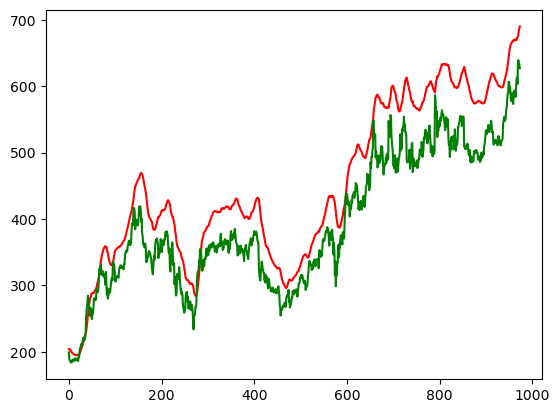

2023/10/27 11:34:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LSTM model (hidden state size=64.000000, learning rate=0.001000, epochs=100.000000):
  RMSE: 60.70705
  MAE: 54.50515
  R2: 0.6479804192210324


In [ ]:
train()

10 epoch loss 0.0048732446
20 epoch loss 0.0043658097
30 epoch loss 0.0037195054
40 epoch loss 0.002643376
50 epoch loss 0.00040594963
60 epoch loss 0.00011779465
70 epoch loss 0.00014201547
80 epoch loss 4.948576e-05
90 epoch loss 2.77393e-05


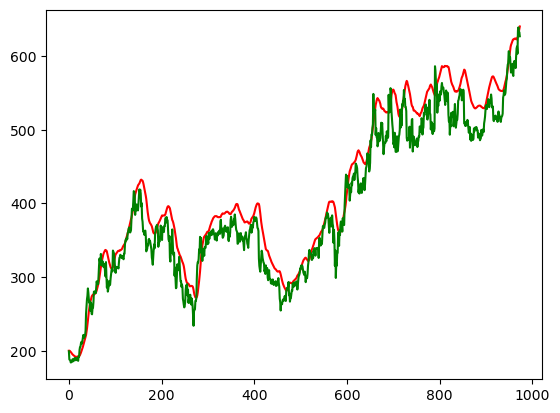

2023/10/27 11:36:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LSTM model (hidden state size=96.000000, learning rate=0.000500, epochs=100.000000):
  RMSE: 31.058548
  MAE: 25.363663
  R2: 0.9078594345806057


In [ ]:
train(96,0.0005,)

10 epoch loss 0.0046533155
20 epoch loss 0.0041197203
30 epoch loss 0.0034018015
40 epoch loss 0.0018696343
50 epoch loss 0.0006177953
60 epoch loss 0.00019225472
70 epoch loss 3.6743844e-05
80 epoch loss 2.3599976e-05
90 epoch loss 2.1016584e-05
100 epoch loss 2.051464e-05
110 epoch loss 1.9875028e-05


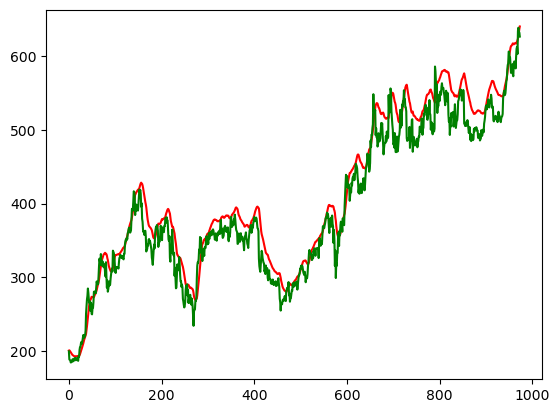

2023/10/27 11:36:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LSTM model (hidden state size=96.000000, learning rate=0.001000, epochs=120.000000):
  RMSE: 26.347303
  MAE: 21.219648
  R2: 0.9336927632026627


In [ ]:
train(96,0.001,120)

10 epoch loss 0.0057120803
20 epoch loss 0.0050772885
30 epoch loss 0.0049914317
40 epoch loss 0.0043379897
50 epoch loss 0.0038305083
60 epoch loss 0.0029965697
70 epoch loss 0.0011408213
80 epoch loss 0.00051020103
90 epoch loss 0.00024075813


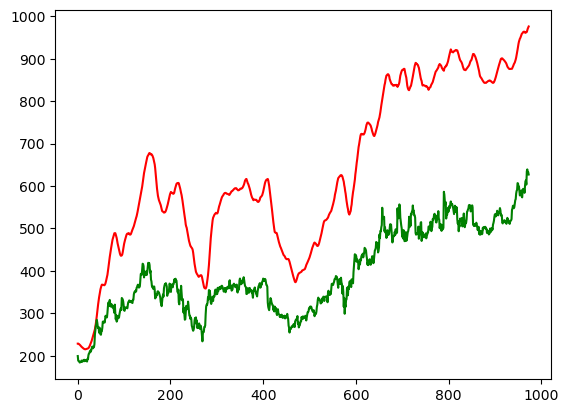

2023/10/27 11:36:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LSTM model (hidden state size=96.000000, learning rate=0.001000, epochs=100.000000):
  RMSE: 258.80853
  MAE: 238.36305
  R2: -5.398021932561431


In [ ]:
train(96,0.001,100)

10 epoch loss 0.005142757
20 epoch loss 0.004488252
30 epoch loss 0.003730749
40 epoch loss 0.0024579542
50 epoch loss 0.0005272455
60 epoch loss 0.0002552274
70 epoch loss 7.012307e-05
80 epoch loss 4.5305394e-05
90 epoch loss 2.6644388e-05


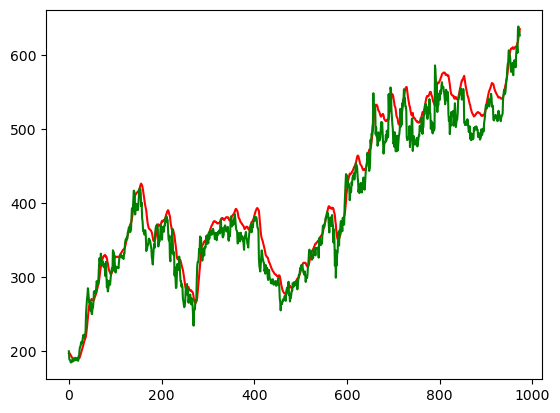

2023/10/27 11:37:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LSTM model (hidden state size=96.000000, learning rate=0.001500, epochs=100.000000):
  RMSE: 23.272957
  MAE: 18.41715
  R2: 0.9482641416372745


In [ ]:
train(96,0.0015,100)

10 epoch loss 0.005105913
20 epoch loss 0.0047501293
30 epoch loss 0.0039941925
40 epoch loss 0.003208082
50 epoch loss 0.0019925681
60 epoch loss 0.00044463668
70 epoch loss 0.00022309908
80 epoch loss 6.123195e-05
90 epoch loss 4.3346696e-05


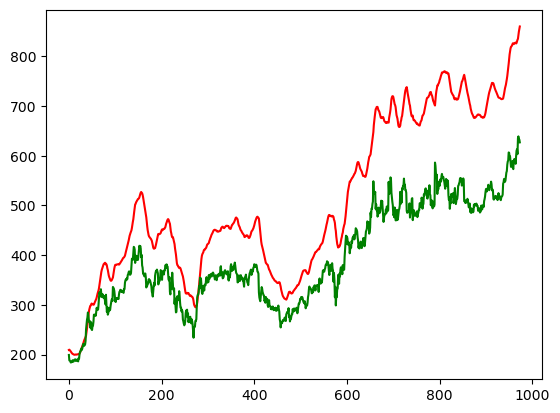

2023/10/27 11:37:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LSTM model (hidden state size=128.000000, learning rate=0.001500, epochs=100.000000):
  RMSE: 131.48164
  MAE: 114.11215
  R2: -0.651272603921949


In [ ]:
train(128,0.0015,100)

10 epoch loss 0.0070435717
20 epoch loss 0.004920821
30 epoch loss 0.0042421464
40 epoch loss 0.0038745126
50 epoch loss 0.0032151684
60 epoch loss 0.0018137334
70 epoch loss 0.00065904256
80 epoch loss 0.00023496595
90 epoch loss 7.2335766e-05


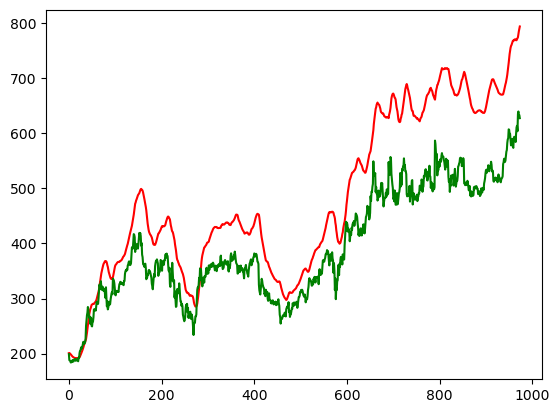

2023/10/27 11:38:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LSTM model (hidden state size=128.000000, learning rate=0.001000, epochs=100.000000):
  RMSE: 101.41294
  MAE: 87.080826
  R2: 0.017629427820585186


In [ ]:
train(128,0.001,100)

10 epoch loss 0.0042176135
20 epoch loss 0.0020863102
30 epoch loss 4.8635367e-05
40 epoch loss 0.00010757002
50 epoch loss 2.7261845e-05
60 epoch loss 2.3104074e-05
70 epoch loss 2.2474156e-05
80 epoch loss 2.0899874e-05
90 epoch loss 1.901023e-05
100 epoch loss 1.7581411e-05
110 epoch loss 1.7165625e-05


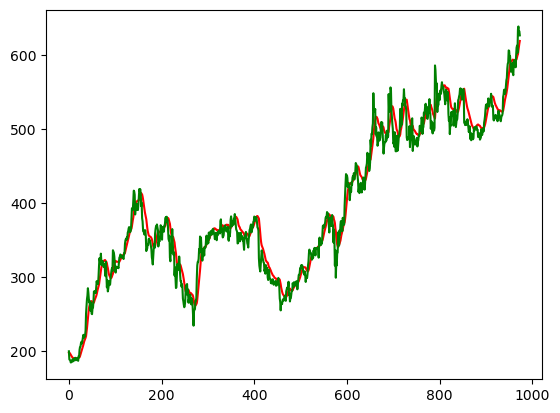

2023/10/27 11:38:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LSTM model (hidden state size=128.000000, learning rate=0.001500, epochs=120.000000):
  RMSE: 17.348997
  MAE: 13.104956
  R2: 0.971250032009778


In [ ]:
train(128,0.0015,120)